# ◆Forex forecast USD／JPY
### 目的：為替予測
### 米ドル円の日足にて、売買予測を行う。
- kaggle URL:https://stooq.com/q/d/?s=usdjpy&c=0
- Create Date：2020/01/15　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 視覚化

### 3.モデル構築
- 各アルゴリズムのハイパーパラメータ探索を行う。（ロジスティック回帰とSVMを利用）

### 4.モデル評価
- 最良のモデルで汎化性能を算出する。
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

### ※データセット
- 「usdjpy_d.csv」

| 列 | 項目 | 項目名 | 欠損有無 | 利用概要 |
|:---:|:---:|:---:|:---:|:---:|
|  1 | Date| 日付 | - | ○ |
|  2 | Open |始値 | - | ○ |
|  3 | High |高値 | - | ○ |
|  4 | Low |底値 | - | ○ |
|  5 | Close |終値 | - | ○ |

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from time                    import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model    import SGDClassifier
from sklearn.svm             import SVC
from sklearn.metrics         import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from IPython.display         import Markdown, display
from matplotlib import ticker
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import matplotlib.dates as mdates
import mpl_finance as mpf
import codecs as cd
import warnings
import mpl_finance
warnings.filterwarnings('ignore')

start_notebook = time()

# ****************************************************************************
# 設定値
# ****************************************************************************

# ▼件数絞込用（時間がかかりすぎるため）
squeeze_num = 1000 # ※1以上の場合有効
train_size = 0.7

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)
    
# ============================================================================
# MarkDown記法
# ============================================================================
def printmd(string):
    display(Markdown('\n\n**' + string + '**'))

# ============================================================================
# 学習曲線を作成
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(12,5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    # 学習曲線
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                           random_state=1234)
    train_scores_mean = np.mean(train_scores, axis=1) # 分割数分のスコアの平均
    train_scores_std  = np.std(train_scores, axis=1) # 分割数分のスコアの標準偏差
    test_scores_mean  = np.mean(test_scores, axis=1) # 分割数分のスコアの平均
    test_scores_std   = np.std(test_scores, axis=1) # 分割数分のスコアの標準偏差
    
    plt.grid()
    # 標準偏差の範囲を色付け（学習データ）
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    # 標準偏差の範囲を色付け（交差検証法）
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    # 学習データのスコアをプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    # 交差検証法スコアをプロット
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# ============================================================================
# 関数：傾きを算出
# ============================================================================
def get_tilt(close):
    
    length = len(close)
    tilt = np.zeros(length)
    
    for i in range(length):
        if i < 1:
            tilt[i] = 0
        else :
            a = pd.Series(close)[i:i+1].values - pd.Series(close)[i-1:i].values
            tilt[i] = a/1
    return tilt

# ============================================================================
# 関数：get_rsi
# ============================================================================
def get_rsi(close, period):
    
    diff = close.diff()
    # 値上がり幅、値下がり幅をシリーズへ切り分け
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    # 値上がり幅/値下がり幅の単純移動平均（period)を処理
    up_sma = up.rolling(window=period, center=False).mean()
    down_sma = down.abs().rolling(window=period, center=False).mean()
    
    # RSIの計算
    rs = up_sma / down_sma
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    return rsi

# ============================================================================
# 関数：get_rci
# ============================================================================
def get_rci(close, period):
    
    rank_period = np.arange(period, 0, -1)
    length = len(close)
    rci = np.zeros(length)
    
    for i in range(length):
        if i < period - 1:
            rci[i] = 0
        else :
            #価格順位取得             
            rank_price = pd.Series(close)[i - period + 1: i + 1].rank(method='min', ascending = False).values
            #rciを取得(int型で取得)
            rci[i] = np.int32((1 - (6 * sum((rank_period - rank_price)**2)) / (period**3 - period)) * 100)
            
    return rci

# ============================================================================
# 関数：get_sma
# ============================================================================
def get_sma(close, period):
    return list(pd.Series(close).rolling(period).mean())

# ============================================================================
# 関数：get_ema
# ============================================================================
def get_ema(close, period):
    return list(pd.Series(close).ewm(span=period).mean())

# 1.データ読込

In [2]:
df= pd.read_csv('./input/usdjpy_d.csv',parse_dates=['Date'])

# column name change
df.rename(columns={'Date' : 'time'}, inplace=True)
df.rename(columns={'Open' : 'open'}, inplace=True)
df.rename(columns={'High' : 'high'}, inplace=True)
df.rename(columns={'Low' : 'low'}, inplace=True)
df.rename(columns={'Close' : 'close'}, inplace=True)

# calc target
df = df.query('time >= "2000-01-01"')

# RCI
df['rci9'] = get_rci(df.close,9)

# RSI
df['rsi14'] = get_rsi(df.close,14)
df['tilt_rsi14'] = get_tilt(df.rsi14)

# tilt(RCI)
df['tilt_rci9'] = get_tilt(df.rci9)

# sma/ema
df['sma5']= get_sma(df.close,5)
df['sma21']= get_sma(df.close,21)
df['ema10']= get_ema(df.close,10)

# tilt(sma/ema)
df['tilt_sma5']= get_tilt(df.sma5)
df['tilt_sma21']= get_tilt(df.sma21)
df['tilt_ema10']= get_tilt(df.ema10)

# ローソク足の長さ
df['day_diff1'] = abs(df.high - df.low)
df['day_diff2'] = abs(df.open - df.close)

# test target
df = df.query('time >= "2001-01-01"')

printmd('▼ size')
display(df.shape)

printmd('▼ 直近10行表示')
display(df.tail(10))



**▼ size**

(4941, 17)



**▼ 直近10行表示**

,time,open,high,low,close,rci9,rsi14,tilt_rsi14,tilt_rci9,sma5,sma21,ema10,tilt_sma5,tilt_sma21,tilt_ema10,day_diff1,day_diff2
12532,2020-01-06,107.806,108.505,107.774,108.378,-85.0,33.025240,8.796329,-4.0,108.5020,109.044810,108.791679,-0.2112,-0.022857,-0.091929,0.731,0.572
12533,2020-01-07,108.378,108.628,108.263,108.458,-88.0,27.843738,-5.181502,-3.0,108.4180,109.030762,108.731010,-0.0840,-0.014048,-0.060669,0.365,0.080
12534,2020-01-08,108.459,109.244,107.651,109.078,-58.0,43.035144,15.191406,30.0,108.5128,109.055429,108.794099,0.0948,0.024667,0.063089,1.593,0.619
12535,2020-01-09,109.078,109.582,109.013,109.480,1.0,48.631518,5.596375,59.0,108.6990,109.098429,108.918809,0.1862,0.043000,0.124709,0.569,0.402
12536,2020-01-10,109.478,109.688,109.437,109.500,48.0,51.757576,3.126057,47.0,108.9788,109.131762,109.024480,0.2798,0.033333,0.105671,0.251,0.022
12537,2020-01-13,109.538,109.947,109.534,109.934,73.0,56.058515,4.300939,25.0,109.2900,109.197762,109.189847,0.3112,0.066000,0.165367,0.413,0.396
12538,2020-01-14,109.935,110.200,109.862,109.988,90.0,58.191460,2.132945,17.0,109.5960,109.221571,109.334966,0.3060,0.023810,0.145119,0.338,0.053
12539,2020-01-15,109.987,110.001,109.790,109.887,95.0,56.951653,-1.239807,5.0,109.7578,109.247952,109.435336,0.1618,0.026381,0.100370,0.211,0.100
12540,2020-01-16,109.887,110.186,109.856,110.178,95.0,58.018114,1.066461,0.0,109.8974,109.274762,109.570366,0.1396,0.026810,0.135030,0.330,0.291
12541,2020-01-17,110.178,110.291,110.051,110.149,93.0,59.818731,1.800617,-2.0,110.0272,109.305000,109.675572,0.1298,0.030238,0.105206,0.240,0.029


# 2. データ可視化

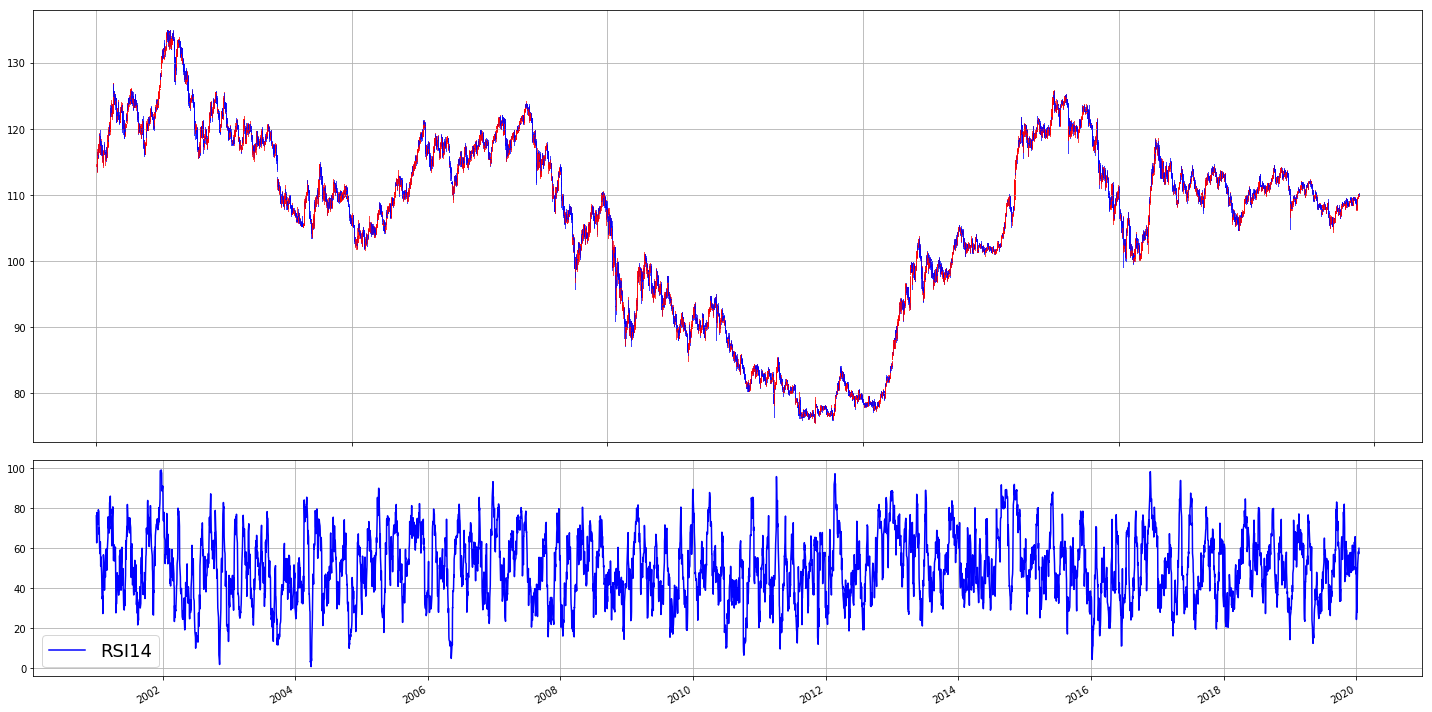

In [3]:
plt.rcParams['figure.figsize'] = [20.0, 10.0]
plt.rc('figure.subplot', left=0.5, right=0.9, bottom=0.1, top=0.9)
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4, 2]})

# --------------------------------------------------------------------------
# ローソク足
mpl_finance.candlestick2_ohlc(ax1,opens=df.open, highs=df.high, lows=df.low, closes=df.close, 
                              width=1,colorup='r', colordown='b')

# x軸を時間にする
xdate = df.index
ax1.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax1.grid(b=True, which='major', axis='both') #グリッド表示
def mydate(x, pos):
    try:
        return xdate[int(x)]
    except IndexError:
        return ''

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')

fig.autofmt_xdate()
fig.tight_layout()

# --------------------------------------------------------------------------
# テクニカルチャート
ax2.plot(df.time, df.rsi14, color='b', antialiased=True, label='RSI14')
ax2.grid(b=True, which='major', axis='both') #グリッド表示

# --------------------------------------------------------------------------

plt.legend(loc='lower left',fontsize=18)
fig.tight_layout()
plt.show()

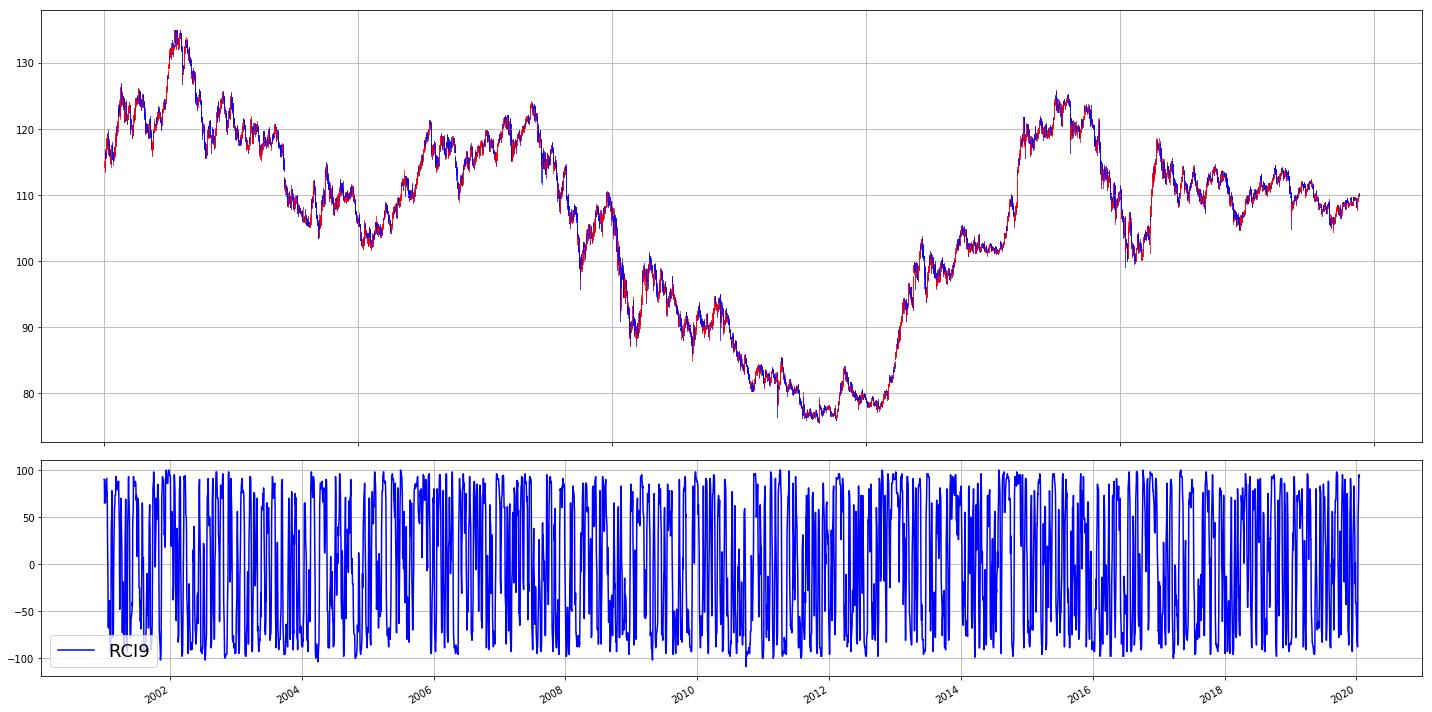

In [4]:
plt.rcParams['figure.figsize'] = [20.0, 10.0]
plt.rc('figure.subplot', left=0.5, right=0.9, bottom=0.1, top=0.9)
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4, 2]})

# --------------------------------------------------------------------------
# ローソク足
mpl_finance.candlestick2_ohlc(ax1,opens=df.open, highs=df.high, lows=df.low, closes=df.close, 
                              width=1,colorup='r', colordown='b')

# x軸を時間にする
xdate = df.index
ax1.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax1.grid(b=True, which='major', axis='both') #グリッド表示
def mydate(x, pos):
    try:
        return xdate[int(x)]
    except IndexError:
        return ''

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')

fig.autofmt_xdate()
fig.tight_layout()

# --------------------------------------------------------------------------
# テクニカルチャート
ax2.plot(df.time, df.rci9, color='b', antialiased=True, label='RCI9')
ax2.grid(b=True, which='major', axis='both') #グリッド表示

# --------------------------------------------------------------------------

plt.legend(loc='lower left',fontsize=18)
fig.tight_layout()
plt.show()


### 翌日終値が当日終値よりも上昇するかを予測する

In [5]:
# 翌日終値 - 当日終値で差分を計算
df['close_1dayAdd'] = df.close.shift(-1)
df['diff'] = df['close_1dayAdd'] - df['close']
df = df[:-1]

# 上昇したら「1」、下降したら「0」へデータを変換
mask1 = df['diff'] >= 0.0   # 上昇した
mask2 = df['diff'] < 0.0

column_name = 'diff'
df.loc[mask1, 'target'] = 1 # 買い
df.loc[mask2, 'target'] = 0 # 様子見

#df.rename(columns={'Diff' : 'Target'}, inplace=True)




**▼ 目的変数 targetの種類（%）**

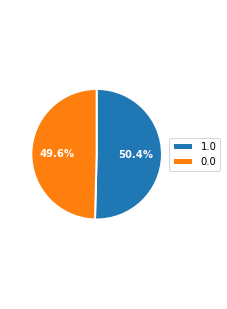

→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。




**▼ Targetが成功または失敗のデータを抽出**

,target
1.0,2490
0.0,2450




**▼ 成功率の平均値**

baseline= 0.5040485829959515


In [6]:
printmd('▼ 目的変数 targetの種類（%）')
per_state = round(df['target'].value_counts() / len(df['target']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(5,5))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()
print('→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。')

printmd('▼ Targetが成功または失敗のデータを抽出')
display(pd.DataFrame(df['target'].value_counts(),columns=['target']))

# 成功率の平均
printmd('▼ 成功率の平均値')
baseline = df['target'].mean()
print('baseline=',baseline)

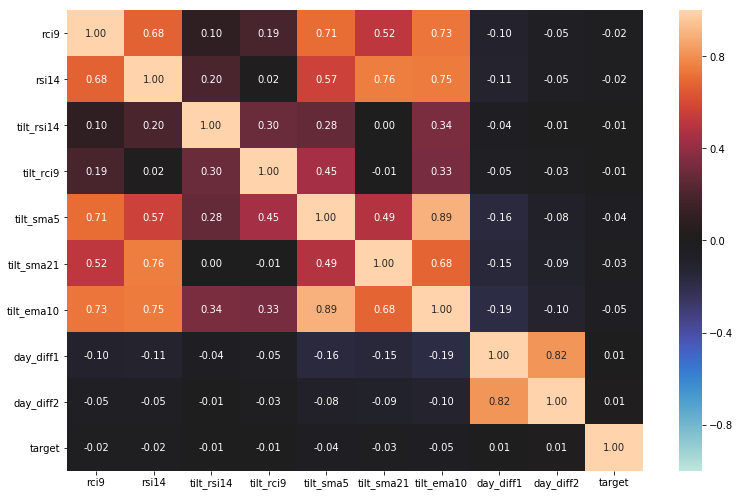

In [7]:
corrmat = df.drop(['time','open','high','low','close','close_1dayAdd','diff','sma5','sma21','ema10'],axis=1).corr()
f, ax = plt.subplots(figsize=(25, 8))
sns.heatmap(corrmat, annot=True, fmt='1.2f', vmax=1, vmin=-1, center=0)

,rci9,rsi14,tilt_rsi14,tilt_rci9,tilt_sma5,tilt_sma21,tilt_ema10,day_diff1,day_diff2
12531,-81.0,24.228911,-25.786797,-20.0,-0.2950,-0.025524,-0.173913,0.780,0.446
12532,-85.0,33.025240,8.796329,-4.0,-0.2112,-0.022857,-0.091929,0.731,0.572
12533,-88.0,27.843738,-5.181502,-3.0,-0.0840,-0.014048,-0.060669,0.365,0.080
12534,-58.0,43.035144,15.191406,30.0,0.0948,0.024667,0.063089,1.593,0.619
12535,1.0,48.631518,5.596375,59.0,0.1862,0.043000,0.124709,0.569,0.402
12536,48.0,51.757576,3.126057,47.0,0.2798,0.033333,0.105671,0.251,0.022
12537,73.0,56.058515,4.300939,25.0,0.3112,0.066000,0.165367,0.413,0.396
12538,90.0,58.191460,2.132945,17.0,0.3060,0.023810,0.145119,0.338,0.053
12539,95.0,56.951653,-1.239807,5.0,0.1618,0.026381,0.100370,0.211,0.100
12540,95.0,58.018114,1.066461,0.0,0.1396,0.026810,0.135030,0.330,0.291




**▼標準化**

<Figure size 1440x720 with 0 Axes>

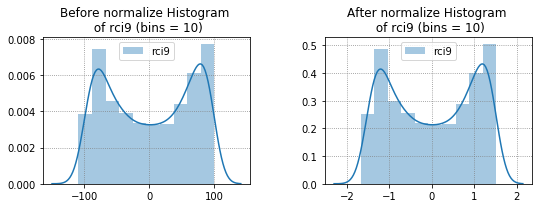

<Figure size 1440x720 with 0 Axes>

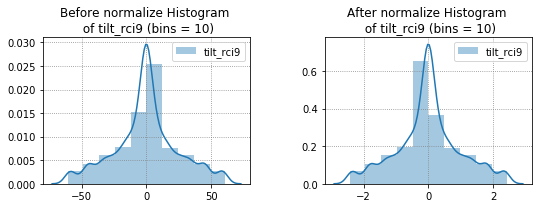

<Figure size 1440x720 with 0 Axes>

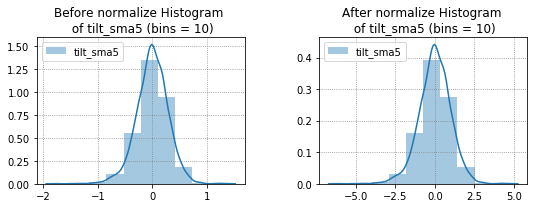

<Figure size 1440x720 with 0 Axes>

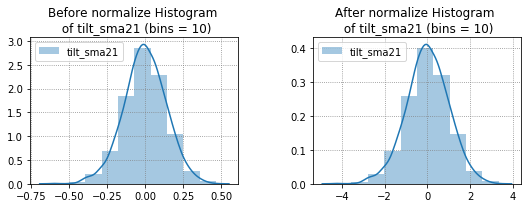

<Figure size 1440x720 with 0 Axes>

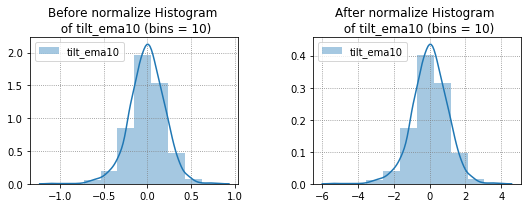

<Figure size 1440x720 with 0 Axes>

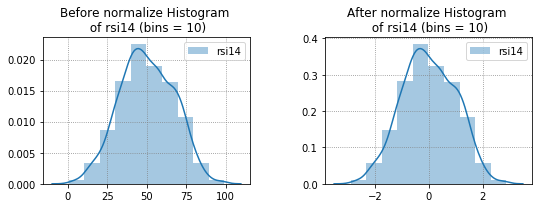

<Figure size 1440x720 with 0 Axes>

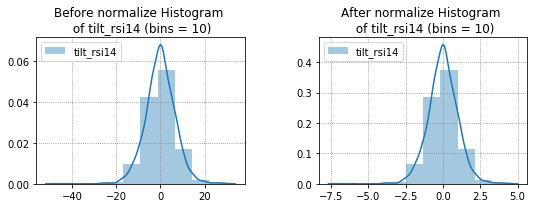

<Figure size 1440x720 with 0 Axes>

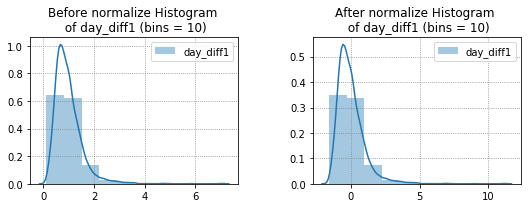

<Figure size 1440x720 with 0 Axes>

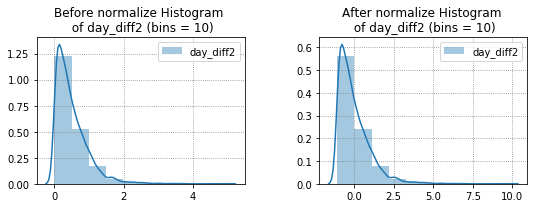

,rci9,rsi14,tilt_rsi14,tilt_rci9,tilt_sma5,tilt_sma21,tilt_ema10,day_diff1,day_diff2
12531,-1.252239,-1.512534,-3.820451,-0.798142,-1.004987,-0.162087,-0.834150,-0.366247,-0.099373
12532,-1.313419,-0.997994,1.305571,-0.159444,-0.716285,-0.143080,-0.433636,-0.456586,0.175684
12533,-1.359304,-1.301085,-0.766268,-0.119525,-0.278065,-0.080287,-0.280923,-1.131357,-0.898345
12534,-0.900456,-0.412465,2.253470,1.197790,0.337924,0.195659,0.323668,1.132630,0.278284
12535,0.001946,-0.085105,0.831263,2.355430,0.652808,0.326335,0.624699,-0.755255,-0.195424
12536,0.720809,0.097753,0.465105,1.876407,0.975272,0.257434,0.531693,-1.341532,-1.024958
12537,1.103182,0.349336,0.639250,0.998197,1.083449,0.490274,0.823325,-1.042862,-0.208522
12538,1.363196,0.474103,0.317903,0.678848,1.065535,0.189550,0.724405,-1.181135,-0.957286
12539,1.439671,0.401580,-0.182017,0.199824,0.568747,0.207879,0.505795,-1.415277,-0.854686
12540,1.439671,0.463963,0.159825,0.000231,0.492265,0.210933,0.675119,-1.195884,-0.437735


In [8]:
# データセットの行数、列数を取得
split_row = np.int(train_size * df.shape[0])
X_all_df = df.drop(['time','open','high','low','close','close_1dayAdd','diff','target','sma5','sma21','ema10'], axis=1)

# 直近の5行を表示
display(X_all_df.tail(10))

# 標準化項目リスト
enc_norm_col = ['rci9',
                'tilt_rci9',
                'tilt_sma5','tilt_sma21',
                'tilt_ema10',
                'rsi14',
                'tilt_rsi14',
                'day_diff1','day_diff2']

# 標準化する列名と列番号の辞書
dic_norm_col = {}
for col_name in enc_norm_col:
    dic_norm_col.setdefault(col_name, X_all_df.columns.get_loc(col_name))
X_columns = X_all_df.columns
    
# -------------------------------------------------
# ndarrayに変換
X_all = X_all_df.values
y_all = df['target'].values

X_train = X_all[:split_row, :]
y_train = y_all[:split_row]

X_test = X_all[split_row+1:,:]
y_test = y_all[split_row+1:]

# -------------------------------------------------
printmd('▼標準化')
for col_name,col_idx in dic_norm_col.items():
    plt.subplots_adjust(wspace=8.0, hspace=2.0) # 余白
    plt.figure(figsize=(8,3))
    
    # 標準化前
    plt.subplot(1,2,1)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('Before normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    
    # 標準化
    stdsc = StandardScaler()
    X_train[:,col_idx:col_idx+1] = stdsc.fit_transform(X_train[:,col_idx:col_idx+1])
    X_test[:,col_idx:col_idx+1] = stdsc.transform(X_test[:,col_idx:col_idx+1])
    
    #　標準化後
    plt.subplot(1,2,2)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('After normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.tight_layout() # 重ならないように
    plt.show()
    
# 直近の5行を表示
display(X_all_df.tail(10))

In [9]:
dic_models = {} # アルゴリズムごとに結果を格納
kfold = KFold(n_splits=5, random_state=1234)

In [10]:
lr_clf = SGDClassifier(loss='log',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
lr_param_grid = {'penalty' : ['none','l1','l2','elasticnet'],#正則化項（default = 'l2'）
                 'alpha' : [1e-4, 1e-3] # 正則化項の効き具合(default = 0.0001:1e-4)
                }
grid = GridSearchCV(estimator=lr_clf, param_grid=lr_param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
dic_models.setdefault('LogisticRegression', grid_result) # 辞書に格納
best_lr = grid_result.best_estimator_
# 結果
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Score: %f (%f) with: %r" % (mean, stdev, param))
    print("----------------------------------------------")
print("★BestScore: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Score: 0.489011 (0.008621) with: {'alpha': 0.0001, 'penalty': 'none'}
----------------------------------------------
Score: 0.495951 (0.014566) with: {'alpha': 0.0001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.489011 (0.008621) with: {'alpha': 0.0001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.511567 (0.007927) with: {'alpha': 0.0001, 'penalty': 'elasticnet'}
----------------------------------------------
Score: 0.505205 (0.016171) with: {'alpha': 0.001, 'penalty': 'none'}
----------------------------------------------
Score: 0.510121 (0.018989) with: {'alpha': 0.001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.505205 (0.015752) with: {'alpha': 0.001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.504338 (0.027668) with: {'alpha': 0.001, 'penalty': 'elasticnet'}
----------------------------------------------
★BestScore: 0.511567 using {'alpha': 0.0001, 'penalty': 'elastic

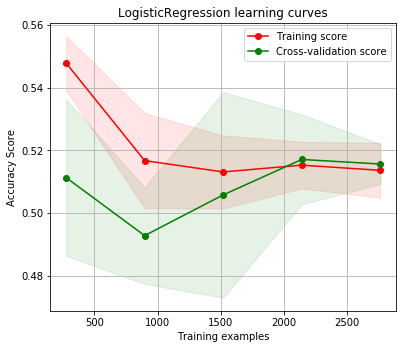

In [11]:
# ロジスティック回帰の学習曲線
plot_learning_curve(best_lr,"LogisticRegression learning curves",X_train,y_train,cv=kfold)



**▼ 重みを表示（絶対値の降順：Top10）**

,feature,weight
0,tilt_ema10,-0.179176
1,rsi14,0.060577
2,rci9,0.000000
3,tilt_rsi14,0.000000
4,tilt_rci9,0.000000
5,tilt_sma5,0.000000
6,tilt_sma21,0.000000
7,day_diff1,0.000000
8,day_diff2,0.000000




**▼ 重みの大きさを横棒グラフで表示**

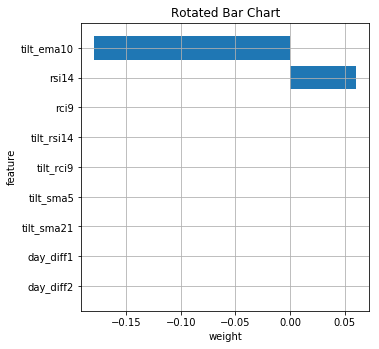



**▼ モデルの評価結果**

正答率（訓練データ） = 50.434%
正答率（テストデータ）= 51.384%
適合率（Precision※精度) = 53.846%
再現率（Recall※検出率) = 1.939%
F1値（F1-score） = 3.743%




**▼ 混同行列**

,予測 = 翌日上昇しない,予測 = 翌日上昇する
正解 = 翌日上昇しない,14,708
正解 =翌日上昇する,12,747




**▼ 70%以上の確率でトレードした場合の勝率**

,0,1,2,3,4,5,6,7,8,pred,actual,max_prob
343,-1.160470,-1.821944,-2.333924,0.000231,-3.978132,-1.738344,-4.549543,8.667578,6.240017,1,1.0,0.733109
463,-1.512253,-1.049644,-1.403346,-0.398955,-3.121673,-1.412843,-3.388462,2.133725,2.397963,1,0.0,0.700399
464,-1.512253,-1.541612,-1.244873,0.000231,-2.964575,-1.703045,-3.619604,2.922802,1.016133,1,1.0,0.702830
519,-0.288658,-0.393426,-0.940009,-1.836026,-3.535778,-2.039069,-3.175193,1.731812,2.500563,1,0.0,0.700722
1212,-1.313419,-2.102274,-1.238642,0.000231,-2.504995,-2.301099,-3.940006,7.174231,5.482521,1,1.0,0.707703


正答率（※閾値指定）= 0.6


In [12]:

# 学習
best_lr.fit(X_train, y_train)

#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# 結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
res_df['feature'] = list(X_all_df.columns)
res_df['weight'] = np.reshape(best_lr.coef_[0], -1).tolist() # 重み
res_df['abs_w'] = abs(res_df['weight']) # 絶対値

# 重みの絶対値の降順ソート
printmd('▼ 重みを表示（絶対値の降順：Top10）')
res_df = res_df.sort_values('abs_w', ascending=False)
res_df.reset_index(drop=True,inplace=True)
res_df = res_df.drop('abs_w', axis=1)
res_df_head = res_df.head(10)
display(res_df_head.head(10))

# 重みの大きさを横棒グラフで表示
printmd('▼ 重みの大きさを横棒グラフで表示')
plt.figure(figsize=(10, 5))
plt.barh(np.arange(len(res_df_head['feature']))[::-1], res_df_head['weight'], align='center')
plt.yticks(np.arange(len(res_df_head['feature']))[::-1], res_df_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('feature')
plt.grid()
plt.show()

y_train_pred = best_lr.predict(X_train) # 訓練データ
y_test_pred = best_lr.predict(X_test) # テストデータ


printmd('▼ モデルの評価結果')
print('正答率（訓練データ） = {:.3f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('正答率（テストデータ）= {:.3f}%'.format(100 * accuracy_score(y_test, y_test_pred)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
printmd('▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 翌日上昇しない', '正解 =翌日上昇する'], 
                        columns=['予測 = 翌日上昇しない', '予測 = 翌日上昇する'])

display(conf_mat)

printmd('▼ 70%以上の確率でトレードした場合の勝率')
# 確率取得（上昇しない確率：上昇する確率）
prob = best_lr.predict_proba(X_test)

# 閾値を指定
max_prob, max_prob_args = [],[]
for i in range(len(prob)):
    max_prob.append(prob[i].max())
    if prob[i].max() > 0.70: # 70%以上の確率データで絞る
        max_prob_args.append(prob[i].argmax())
    else:
        max_prob_args.append(-1)
a = pd.DataFrame(X_test)
a['pred'] = max_prob_args
a['actual'] = y_test
a['max_prob'] = max_prob
b = a[a['pred'] != -1]
display(b.head(10))
print('正答率（※閾値指定）=',accuracy_score(b['pred'], b['actual']))